<a href="https://colab.research.google.com/github/tony-held/carb_2023/blob/main/arb_satellite_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fictitious Satellite and Facility Response Database Analysis

## Introduction

This jupyter notebook presents the methodology and results of the fictitious satellite and facility response database by Tony Held (tony.held@gmail.com).

A jupyter notebook is an interactive way to run python and was selected for this analysis for the following reasons:

* Jupyter notebook code can be annotated/documented so that all analysis assumptions are explicit and all results are reproducible.
* Notebooks can be shared/cloned to allow 3rd parties to explore analysis approaches and to suggest enhancements through code repository systems such as git.
* The python packages are all open source and free so there are no licensing fees.
* Jupyter cells can be modified and alternative analysis can be explored for quick prototyping.

## How to View and/or Run This Notebook
It is recommended that this notebook be viewed and/or run from Google Colabs to ensure that required analysis packages are properly installed.  Google Colabs is free (like Google Doc or Google Sheet) but it does require a google account.

If you wish only to view the file, you can scroll the file and read its contents like a word document in read-only mode.  If you wish to change and or run the notebook, the notebook should be cloned to your google account (in Google Drive) and then run directly in Colab.

Google has a great intro on how to get started in Colab which can bee seen here: https://colab.research.google.com/

There are a variety of ways to put this notebook on your Google Drive and view/run the notebook.  One approach would be the following:
* Download this file to your local hard drive
* Open google colab in your browser: https://colab.research.google.com/
* Select File -> Upload Notebook and select this file on your local drive
* Select File -> Save a Copy to Drive to put a copy of this notebook on your Google Drive in the Colabs folder.  This will also open a new window with the notebook now hosted on your drive.
* You can run/edit the Colab notebook in the new window as you have read/write permission to run notebooks that are in your Drive.
* View the file first to see the original results in view mode
* Select Runtime -> Run all to run all cells in the notebook and redo the data analysis.

# Install Required Python Packages
The Python language has a rich set of packages (also know as libraries) for scientific computing.  The following lines of code will ensure that the required packages for this analysis will be installed on the local machine/server.


In [ ]:
# No additional packages require installation for this analysis if using Google Colab

# Import Required Python Packages
Python libraries need to be imported so that they can be called by subsequent code.

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import seaborn as sns
import sys
import urllib.request
import warnings

from enum import Enum
from pathlib import Path

# Ticketing and Ticket Manager Related Source Code

## Enumeration and Constants
* Enumerated classes are used to store record and event types
* Enumeration avoids the use of "magic numbers" in the code and can often avoid off-by-one issues when number systems start with zero or one.
* The Enumerations are based on on the input files:
    * record_type.csv,
    * satellite_event_status.csv,
    * operator_even_status.csv

In [ ]:
class Constants:
  seconds_per_day = 60. * 60. * 24.


class RecordType(Enum):
  """"
  Flag to indicate if a event record is a satellite observation or a facility response.
  """
  satellite_observation = 1
  facility_response = 2


class SatelliteEvent(Enum):
  """
  Flag to indicate the type of satellite event type.
  """
  no_methane_plume = 0
  small_methane_plume = 1
  medium_methane_plume = 2
  large_methane_plume = 3
  cloud_cover = 4


class OperatorEvent(Enum):
  """
  Flag to indicate the type of operator event type.
  """

  no_leak_detected = 0
  leak_confirmed = 1
  leak_fixed = 2

## Ticket Class

In [ ]:
class Ticket:
  """
  The ticket class is used identify plume detections and associated facility responses.

  Notes:
    1) A new ticket should be created when a satellite detects a plume at a facility
    that does not already have an open ticket.
    2) A ticket will log any additional satellite measurements and operator responses
    until the ticket is closed.
    3) A ticket is closed when an operator indicates that they performed an on-site survey
    which determined that a leak was fixed.
    4) A no_leak_detected will be logged, but will not close a ticket.
    5) The ticketing logic can be modified if one desires so that a ticket is closed by
    differing logic.  For example, CARB may create a ticket closure mechanism based on
    multiple satellite non-detects after an operator was not able to confirm a plume.
    """
  # id_class is a unique class id for each ticket objects
  id_class = itertools.count()

  def __init__(self, index, row):
    """
    Create a new ticket.  A ticket can only be created when there is a
    satellite plume detection associated with a facility that does not
    already have an open ticket.

    Args:
      index (int): data file row number
      row: a single row of data
    """
    self.validate_creation(row)

    # Initialize Ticket attributes
    self.id = next(Ticket.id_class)
    self.is_open = True
    self.location_id = row['Location_ID']
    self.industrial_sector = row['Industrial_Sector']
    self.creation_time = row['Timestamp']
    self.confirmed_time = None
    self.no_leak_detected_time = None
    self.fixed_time = None
    self.closed_time = None
    self.operator_responses = []
    self.plume_count = 0
    self.plume_count_after_no_leak_detected = 0
    self.satellite_non_plume_count = 0
    # sat_detects dictionary keyed off satellite observation type
    # with its values a list of database row indices associated with satellite measurements
    self.sat_detects = {
      SatelliteEvent.no_methane_plume: [],
      SatelliteEvent.small_methane_plume: [],
      SatelliteEvent.medium_methane_plume: [],
      SatelliteEvent.large_methane_plume: [],
      SatelliteEvent.cloud_cover: [],
    }
    # The next line appends the satellite event associated with the
    # creation of this ticket to the sat_detects dictionary.
    self.sat_detects[SatelliteEvent(row['Event_Status'])].append(index)
    self.plume_count += 1

  def validate_creation(self, row):
    """
    Ensure that a ticket can only be initialized with a row that is a plume detection.
    """
    record_type = RecordType(row['Record_Type'])
    if record_type != RecordType.satellite_observation:
      raise ValueError(f"Ticket can only be initialized with a satellite measurement."
                       f"Invalid measurement type: {record_type=}")
    # Ensure first measurement is a plume (not a non-detect nor cloudy measurement)
    satellite_event = SatelliteEvent(row['Event_Status'])
    if satellite_event not in (SatelliteEvent.small_methane_plume,
                               SatelliteEvent.medium_methane_plume,
                               SatelliteEvent.large_methane_plume):
      raise ValueError(f"Ticket can only be created with a detected plume."
                       f"Invalid creation type: {satellite_event=}")

  def add_row(self, index, row):
    """
    Add an event to an existing ticket.  If the event is the first facility response,
    the initial response time will be saved.  The ticket will be closed if the
    facility reports a leak fixed event.

    Args:
      index (int): data file row number
      row: a single row of data
    """
    if RecordType(row['Record_Type']) == RecordType.satellite_observation:
      # Log any satellite event and keep ticket open
      self.log_satellite_event(index, row)
    else:
      # Log facility response
      self.log_operator_response(index, row)

  def log_satellite_event(self, index, row):
    """
    Update ticket info related to satellite detects including:
      1) update sat_detects dictionary
      2) potentially update plume_count, satellite_non_plume_count, and
      plume_count_after_no_leak_detected
    Args:
      index (int): data file row number
      row: a single row of data
    """
    event_status = SatelliteEvent(row['Event_Status'])
    self.sat_detects[event_status].append(index)

    # Update plume count if plume detected
    if event_status in (SatelliteEvent.small_methane_plume,
                        SatelliteEvent.medium_methane_plume,
                        SatelliteEvent.large_methane_plume):
      self.plume_count += 1
      # If plume_count_after_no_leak_detected if operator previously
      # indicated that no leak was detected
      if self.no_leak_detected_time is not None:
        self.plume_count_after_no_leak_detected += 1
    else:
      self.satellite_non_plume_count += 1

  def log_operator_response(self, index, row):
    """
    Check and save the associated timestamp if a facility has indicated
    that a leak was not found, confirmed, or fixed.

    Args:
      index (int): data file row number
      row: a single row of data
    """
    time_stamp = row['Timestamp']
    event_status = OperatorEvent(row['Event_Status'])
    self.operator_responses.append(index)

    if event_status == OperatorEvent.leak_confirmed:
      self.confirmed_time = time_stamp
    elif event_status == OperatorEvent.no_leak_detected:
      self.no_leak_detected_time = time_stamp
    elif event_status == OperatorEvent.leak_fixed:
      # A fix should only happen after a confirmation
      # Warn if the data fail this consistency check
      if self.is_confirmed() is False:
        message = f"Data consistency warning. A leak fixed event" \
                  f"occurs before a leak confirmed for a facility." \
                  f"data row: {row}"
        warnings.warn(message)
      # log fixed and closed times and close the ticket
      self.fixed_time = time_stamp
      self.closed_time = time_stamp
      self.is_open = False

  def is_confirmed(self) -> bool:
    """
    Test if the operator has confirmed the leak.
    """
    if self.confirmed_time is not None:
      return True
    else:
      return False

  def is_fixed(self) -> bool:
    """
    Test if the operator has fixed the leak.
    """
    if self.fixed_time is not None:
      return True
    else:
      return False

  def is_no_leak_detected(self) -> bool:
    """
    Test if the operator has indicated that no leak was detected.
    """
    if self.no_leak_detected_time is not None:
      return True
    else:
      return False

  def is_confirmed_not_fixed(self) -> bool:
    """
    Test if the operator has confirmed the leak, but has not fixed it yet.
    """
    if self.is_confirmed() and not self.is_fixed():
      return True
    else:
      return False

  def is_confirmed_and_fixed(self) -> bool:
    """
    Test if the operator has both confirmed and fixed the leak.
    """
    if self.is_confirmed() and self.is_fixed():
      return True
    else:
      return False

  def __repr__(self):
    """
    Represent a ticket object as a string for detailed diagnostics.
    Includes all information from __str__ along with detailed
    satellite detection info.
    """
    diag_dict = self.diagnostic_dict()
    diag_dict['satellite_data'] = self.sat_detects
    my_str = pprint.pformat(diag_dict, indent=4, sort_dicts=False)
    return my_str

  def __str__(self):
    """
    Represent a ticket object as a string for simplified diagnostics.
    """
    diag_dict = self.diagnostic_dict()
    my_str = pprint.pformat(diag_dict, indent=4, sort_dicts=False)
    return my_str

  def diagnostic_dict(self) -> dict:
    """
    Create diagnostic dictionary used in both __repr__ and __str__
    """
    total_sat_measurements = self.plume_count + self.satellite_non_plume_count

    diag_dict = {'id': self.id, 'location id': self.location_id,
                 'is_open': self.is_open, 'sector': self.industrial_sector,
                 'creation_time': self.creation_time, 'confirm_time': self.confirmed_time,
                 'fixed_time': self.fixed_time,
                 'satellite plume count': self.plume_count,
                 'self.satellite_non_plume_count': self.satellite_non_plume_count,
                 'satellite measurement count': total_sat_measurements,
                 'self.plume_count_after_no_leak_detected': self.plume_count_after_no_leak_detected,
                 }

    return diag_dict

## Ticket Manager Class

In [ ]:
class TicketManager:
  """
  TicketManager (TM) creates and updates a ticket database based on event processing.
  TM has a variety of utility functions (count_confirmed_plumes, etc) to determine
  metrics of interest associated with the ticket database.

  Notes:
    1. A ticket can only be created by a positive satellite measurement if there is
    not already a ticket open for the facility.
    2. If a facility registers an event that is not associated with an active ticket,
    or if a non-detect satellite measurement is made when there is no active ticket,
    the event is considered 'orphaned'.
    3. Orphaned data are saved for diagnostics, but are not necessary for ticketing.
    4. The self.ticket dictionary is the primary TM data structure.
      A. Its keys are the facility ids, its values are lists of tickets associated with the facility
      B. Tickets are stored sequentially in the ticket list by creation date.
      C. Only one ticket associated with a facility can be open at a time.
      D. If a facility has an open ticket, it will be the last member of the ticket list
    5. location_ids stores which facility locations have one or more events of any kind.
      A.  it is stored as a is a set to ensure each member is unique
  """

  def __init__(self):
    """
    Create a new TicketManager
    """
    # Primary TicketManagers fields
    self.tickets = {}
    self.location_ids = set()
    self.rows_processed = 0
    self.plume_count = 0
    self.open_ticket_count = 0
    self.closed_ticket_count = 0

    # Orphan related fields that are retained only for diagnostics and debugging
    # list of records that have facility response before satellite measurements
    self.orphan_facilities = []
    # list of records that have cloudy satellite measurements not associated with open ticket
    self.orphan_clouds = []
    # list of records that have no_plume_detected event not associated with open ticket
    self.orphan_no_plumes = []

  def verify_location(self, location_id):
    """
    Ensure that a location_id is in the facility_tickets dictionary
    """
    if location_id not in self.tickets:
      self.tickets[location_id] = []

  def get_open_ticket(self, location_id):
    """
    Get the open ticket associated with a facility (if it exists).

    Args:
      location_id (int):
    Returns (Ticket|None):
      Returns a Ticket if one is open for the location, otherwise returns None.
    """
    if location_id not in self.tickets:
      return None
    # -1 to get the last ticket in the list associated with this facility
    last_ticket = self.tickets[location_id][-1]
    # Return the ticket if it is open, otherwise return None
    if last_ticket.is_open is True:
      return last_ticket
    else:
      return None

  def create_ticket(self, location_id, index, row):
    """
    Create an open Ticket for a location based on an satellite plume detection.
    Args:
      location_id (int):
      index (int): data file row number
      row: a single row of data

    Returns (Ticket):
    """
    self.verify_location(location_id)
    ticket = Ticket(index, row)
    self.tickets[location_id].append(ticket)
    self.open_ticket_count += 1
    return ticket

  def add_row(self, index, row):
    """
    Process a row of data from the event record database.

    Methodology Notes:
      1) Determine if there is an open ticket associated with the facility.
      2) If there is an open ticket, save all information from the data row to the
      ticket (even if it is cloudy or non-detect).
      3) If the facility associated with the event does not have an open ticket,
      then non-plume detection events (operator response, cloud-cover, or no-plume detected)
      will be orphaned (i.e., not associated with a ticket).
      4) If there is no open ticket associated with the facility, and the event being processed
      is a plume detection measurement, then create a new ticket.
      5) This method (TicketManager.add_row) uses Ticket.add_row to save event information to
      the appropriate ticket.

    Args:
      index (int): data file row number
      row: a single row of data
    """
    # print(f"{self.rows_processed}, "
    #       f"{len(self.orphan_facilities)},"
    #       f"{len(self.orphan_clouds)},"
    #       f"{len(self.orphan_no_plumes)},"
    #       )
    self.rows_processed += 1
    location_id = row['Location_ID']
    record_type = row['Record_Type']
    event_status = row['Event_Status']

    self.location_ids.add(location_id)

    # Get the open ticket associated for the location
    # Ticket will be None if there is not an open ticket.
    ticket = self.get_open_ticket(location_id)

    # Case 1.  Orphan a facility response not associated with an open ticket
    if RecordType(record_type) == RecordType.facility_response:
      if ticket is None:
        self.orphan_facilities.append(index)
        return

    # Case 2. Orphan a cloudy measurement not associated with an open ticket
    if RecordType(record_type) == RecordType.satellite_observation:
      if SatelliteEvent(event_status) == SatelliteEvent.cloud_cover:
        if ticket is None:
          self.orphan_clouds.append(index)
          return

    # Case 3. Orphan a no_plume measurement not associated with an open ticket
    if RecordType(record_type) == RecordType.satellite_observation:
      if SatelliteEvent(event_status) == SatelliteEvent.no_methane_plume:
        if ticket is None:
          self.orphan_no_plumes.append(index)
          return

    # Case 4. Non-orphaned record data will will be added to a ticket
    if ticket is None:
      # Create ticket if one is not open
      # When you create a ticket, it automatically adds the row
      ticket = self.create_ticket(location_id, index, row)
    else:
      # Add record information to existing ticket
      # Note, add_row may close the ticket if warranted (operator fixed leak)
      ticket.add_row(index, row)

    # Update total plume detection count
    if RecordType(record_type) == RecordType.satellite_observation:
      if SatelliteEvent(event_status) in (SatelliteEvent.small_methane_plume,
                                          SatelliteEvent.medium_methane_plume,
                                          SatelliteEvent.large_methane_plume):
        self.plume_count += 1

    # Update number of closed tickets
    # The ticket.add_row method may have closed the ticket
    if ticket.is_open is False:
      self.open_ticket_count -= 1
      self.closed_ticket_count += 1

  def count_confirmed_plumes(self):
    """
    Find the number of times facilities confirmed a leak and the associated number
    of plumes confirmed.

    Methodology Notes:
    1) A ticket is always initiated by a satellite detection and all subsequent
    satellite plume detections are logged until the ticket is closed.
    2) A ticket can only be closed by a leak_fixed event from an operator.
    3) confirm_counts are the number of times an operator confirmed a leak
    4) plume_counts is the number of plumes associated with a confirm event
    5) To count the confirmed/fixed plumes, check if the ticket has been
    identified as 'confirmed' by the operator, and if so, sum the number of
    small, medium, and large plume detections for each ticket associated with the
    ticket.
    """
    confirm_counts = {'Dairy': 0,
                      'Landfill': 0,
                      'Oil and Gas': 0,
                      'All Sectors': 0}
    plume_counts = {'Dairy': 0,
                    'Landfill': 0,
                    'Oil and Gas': 0,
                    'All Sectors': 0}

    for location_id, ticket_list in self.tickets.items():
      # print(f"Processing facility: {location_id}")
      for ticket in ticket_list:
        sector = ticket.industrial_sector
        if ticket.is_confirmed() is True:
          confirm_counts[sector] += 1
          confirm_counts['All Sectors'] += 1
          # print(ticket)
          for key in (SatelliteEvent.small_methane_plume,
                      SatelliteEvent.medium_methane_plume,
                      SatelliteEvent.large_methane_plume):
            plume_count = len(ticket.sat_detects[key])
            # print(f"{plume_count}: {key}")
            plume_counts[sector] += plume_count
            plume_counts['All Sectors'] += plume_count
    return confirm_counts, plume_counts

  def confirm_durations(self):
    """
    Calculate the time (in fractional days) it takes for an operator to report that a plume
    was confirmed.

    Methodology Notes:
    1) A ticket timestamp is logged when the ticket is created and identified by
    the operator as confirmed.  The difference between these times is
    considered the confirmation duration time.
    2) The durations are stored separately by sector for subsequent analysis.

    Returns (dict):
      A dictionary keyed by sector with its values representing a list of confirmation
      durations for each facility where an operator confirmed a leak.
    """
    confirm_durations = {'Dairy': [],
                         'Landfill': [],
                         'Oil and Gas': [],
                         'All Sectors': []}

    for location_id, ticket_list in self.tickets.items():
      for ticket in ticket_list:
        sector = ticket.industrial_sector
        if ticket.is_confirmed() is True:
          # _td signifies class type is pandas.Timedelta
          duration_td = ticket.confirmed_time - ticket.creation_time
          # convert from Timedelta to days
          duration = duration_td.total_seconds() / Constants.seconds_per_day
          confirm_durations[sector].append(duration)
          confirm_durations['All Sectors'].append(duration)

    return confirm_durations

  def fix_durations(self):
    """
    Calculate the time (in fractional days) it takes for an operator to report that a plume
    was fixed since it was last confirmed.

    Methodology Notes:
    1) A ticket timestamp is logged when the ticket is confirmed or fixed by the operator.
    The difference between these times is considered the fix time.
    2) The durations are stored separately by sector for subsequent analysis.

    Returns (dict):
      A dictionary keyed by sector with its values representing a list of fix times
      for each facility where an operator fixed a leak.
    """
    fix_durations = {'Dairy': [],
                     'Landfill': [],
                     'Oil and Gas': [],
                     'All Sectors': []}

    for location_id, ticket_list in self.tickets.items():
      for ticket in ticket_list:
        sector = ticket.industrial_sector
        if ticket.is_fixed() is True:
          # _td signifies class type is pandas.Timedelta
          duration_td = ticket.fixed_time - ticket.confirmed_time
          # convert from Timedelta to days
          duration = duration_td.total_seconds() / Constants.seconds_per_day
          fix_durations[sector].append(duration)
          fix_durations['All Sectors'].append(duration)

    return fix_durations

  def plume_after_fix(self):
    """
    Find the number of plumes detected at a facility after
    the facility FIRST reported a leak fixed.

    Methodology Notes:
    1) Tickets associated with a facility are saved as a list in chronological order.
    2) A ticket is closed when the operator indicates it is fixed.
    3) If present, any tickets subsequent to a ticket closed as fixed represent plumes
    that occurred after an operator FIRST indicted the leak was fixed.
    4) For this calculation, all satellite detections at a facility will be counted
    after an operator FIRST indicated a leak was fixed, subsequent operator events
    at the facility such as (no plume detected, or leak fixed) are immaterial.

    Returns
      plume_by_sector_counts (dict):
        A dictionary keyed by sector with its values representing the number of plumes detected
        at a facility after an operator indicated it fixed a leak.
      plume_by_facility_counts (dict):
        A dictionary keyed by facility with its values representing the number of plumes detected
        at a facility after an operator indicated it fixed a leak.
    """
    plume_by_sector_counts = {'Dairy': 0,
                              'Landfill': 0,
                              'Oil and Gas': 0,
                              'All Sectors': 0}
    plume_by_facility_counts = {}

    for location_id, ticket_list in self.tickets.items():
      # flag to indicate that a facility listed a plume as fixed
      fix_reported = False
      for ticket in ticket_list:
        sector = ticket.industrial_sector

        # Find first instance that this facility reported a fix
        # and continue to the next ticket
        if fix_reported is False and ticket.is_fixed() is True:
          fix_reported = True
          continue

        if fix_reported is True:
          for key in (SatelliteEvent.small_methane_plume,
                      SatelliteEvent.medium_methane_plume,
                      SatelliteEvent.large_methane_plume):
            plume_count = len(ticket.sat_detects[key])
            # print(f"{plume_count}: {key}")
            plume_by_sector_counts[sector] += plume_count
            plume_by_sector_counts['All Sectors'] += plume_count
            if location_id not in plume_by_facility_counts:
              plume_by_facility_counts[location_id] = 0
            plume_by_facility_counts[location_id] += plume_count

    return plume_by_sector_counts, plume_by_facility_counts

  def unresolved_plumes(self):
    """
    Find the number of plumes for each facility that are considered unresolved.

    Methodology Notes:
    1) Tickets associated with a facility are saved as a list in chronological order.
    2) A ticket is closed when the operator indicates it is fixed.
    3) If the LAST ticket is open, then the operator has not indicated that the leak was fixed
    4) All plumes associated with the LAST open ticket are considered unresolved.
    6) unresolved_plumes differs from plume_after_fix because unresolved counts plumes
    after the LAST ticket labeled fixed where as plume_after_fix counts after the FIRST ticket
    labeled fixed.
    Returns
      plume_by_sector_counts (dict):
        A dictionary keyed by sector with its values representing the number of plumes detected
        at a facility after an operator indicated it fixed a leak.
      plume_by_facility_counts (dict):
        A dictionary keyed by facility with its values representing the number of plumes detected
        at a facility after an operator indicated it fixed a leak.
    """
    plume_by_sector_counts = {'Dairy': 0,
                              'Landfill': 0,
                              'Oil and Gas': 0,
                              'All Sectors': 0}
    plume_by_facility_counts = {}

    for location_id, ticket_list in self.tickets.items():
      last_ticket = ticket_list[-1]
      # if the last ticket is marked as fixed, then there
      # are no outstanding plumes for this facility
      if last_ticket.is_fixed():
        continue
      else:
        sector = last_ticket.industrial_sector
        if location_id not in plume_by_facility_counts:
          plume_by_facility_counts[location_id] = 0
        for key in (SatelliteEvent.small_methane_plume,
                    SatelliteEvent.medium_methane_plume,
                    SatelliteEvent.large_methane_plume):
          plume_count = len(last_ticket.sat_detects[key])
          # print(f"{plume_count}: {key}")
          plume_by_sector_counts[sector] += plume_count
          plume_by_sector_counts['All Sectors'] += plume_count
          plume_by_facility_counts[location_id] += plume_count

    return plume_by_sector_counts, plume_by_facility_counts

  def plume_after_no_leak_found(self):
    """
    Find the number of plumes detected after a facility FIRST reported no leak found.

    Methodology Notes:
    1) Tickets associated with a facility are saved as a list in chronological order.
    2) Each ticket maintains a count of plumes that occurred after a 'no leak detected' event.
    3) The tickets associated with a facility are inspected in chronological order,
    if a ticket has a no leak detected event, then the number of plumes detected is
    initialized with value.
    4) All subsequent tickets occur after a ticket with a 'no leak detected' event are
    added to the plume count.

    Returns
      plume_by_sector_counts (dict):
        A dictionary keyed by sector with its values representing the number of plumes detected
        at a facility after an operator indicated it fixed a leak.
      plume_by_facility_counts (dict):
        A dictionary keyed by facility with its values representing the number of plumes detected
        at a facility after an operator indicated it fixed a leak.
      """
    plume_by_sector_counts = {'Dairy': 0,
                              'Landfill': 0,
                              'Oil and Gas': 0,
                              'All Sectors': 0}
    plume_by_facility_counts = {}

    for location_id, ticket_list in self.tickets.items():
      # flag to indicate that a facility listed a plume as fixed
      no_leak_reported = False
      for ticket in ticket_list:
        sector = ticket.industrial_sector

        # Find first ticket that a facility reported no leak detected event
        # Initialize plume counts with the tickets plume_counts_after_no_leak
        # data and then continue to the next ticket
        if no_leak_reported is False and ticket.is_no_leak_detected() is True:
          no_leak_reported = True
          plumes_after_no_leak = ticket.plume_count_after_no_leak_detected
          plume_by_sector_counts[sector] += plumes_after_no_leak
          plume_by_sector_counts['All Sectors'] += plumes_after_no_leak
          if location_id not in plume_by_facility_counts:
            plume_by_facility_counts[location_id] = plumes_after_no_leak
            continue

        if no_leak_reported is True:
          for key in (SatelliteEvent.small_methane_plume,
                      SatelliteEvent.medium_methane_plume,
                      SatelliteEvent.large_methane_plume):
            plume_count = len(ticket.sat_detects[key])
            # print(f"{plume_count}: {key}")
            plume_by_sector_counts[sector] += plume_count
            plume_by_sector_counts['All Sectors'] += plume_count
            plume_by_facility_counts[location_id] += plume_count

    return plume_by_sector_counts, plume_by_facility_counts

  def fixed_plumes(self):
    """
    Count plumes associated with tickets closed with an operator fixed leak event.
    """
    plume_by_sector_counts = {'Dairy': 0,
                              'Landfill': 0,
                              'Oil and Gas': 0,
                              'All Sectors': 0}

    for location_id, ticket_list in self.tickets.items():
      for ticket in ticket_list:
        sector = ticket.industrial_sector
        if ticket.is_fixed():
          for key in (SatelliteEvent.small_methane_plume,
                      SatelliteEvent.medium_methane_plume,
                      SatelliteEvent.large_methane_plume):
            plume_count = len(ticket.sat_detects[key])
            # print(f"{plume_count}: {key}")
            plume_by_sector_counts[sector] += plume_count
            plume_by_sector_counts['All Sectors'] += plume_count
    return plume_by_sector_counts

  def plumes_by_location_id(self, location_id):
    """
    Find all the plumes associated with a single location_id
    """
    if location_id not in self.tickets:
      return 0
    plumes = 0
    tickets = self.tickets[location_id]
    for ticket in tickets:
      plumes += ticket.plume_count
    return plumes

  def __str__(self):
    """
    Represent a TicketManager as a string for simplified diagnostics.
    """
    my_str = ['Ticket Manager Data Summary\n']
    str_dict = self.diagnostic_dict()
    for key, value in str_dict.items():
      my_str.append(f"{key}: {value}")
    my_str = "\n".join(my_str)
    return my_str

  def __repr__(self, verbose=0):
    """
    Represent a TicketManager as a string for detailed diagnostics.
    """
    repr_dict = self.diagnostic_dict()
    repr_dict['tickets'] = self.tickets
    if verbose > 0:
      repr_dict['Unique locations'] = self.location_ids
      repr_dict['orphans - facility'] = self.orphan_facilities
      repr_dict['orphans - cloud'] = self.orphan_clouds
      repr_dict['orphans - no_plume'] = self.orphan_no_plumes
    my_str = pprint.pformat(repr_dict, indent=4, sort_dicts=False)
    return my_str

  def diagnostic_dict(self, verbose=1) -> dict:
    """
    Create diagnostic dictionary used in both __repr__ and __str__

    """
    num_tickets = 0
    num_confirms = 0
    num_fixed = 0

    for tickets in self.tickets.values():
      for ticket in tickets:
        num_tickets += 1
        if ticket.is_confirmed():
          num_confirms += 1
        if ticket.is_fixed():
          num_fixed += 1

    diag_dict = {'Number of data rows processed': self.rows_processed,
                 'Number of unique location IDs': len(self.location_ids),
                 'Total plumes detected': self.plume_count,
                 'Number of plume confirmations': num_confirms,
                 'Number of plume fixed': num_fixed,
                 'Number of total tickets': num_tickets,
                 'Number of open tickets': self.open_ticket_count,
                 'Number of closed tickets': self.closed_ticket_count,
                 }
    if verbose > 0:
      diag_dict_2 = {'Number of orphaned facility responses': len(self.orphan_facilities),
                     'Number of orphaned cloudy events': len(self.orphan_clouds),
                     'Number of orphaned no plume events': len(self.orphan_no_plumes),
                     }
      diag_dict.update(diag_dict_2)
    return diag_dict

## Plotting and Utility Functions
Additional utility functions helpful for this analysis

In [ ]:
def dict_to_data_frame(data_dict):
  """
  Convert a dictionary keyed by column_names with values as a list into
  a dataframe.  Unlike creating a DataFrame directly from a dictionary,
  the length of data in each list can be of varying length.

  Notes:
    1) Each series will be NaN (Not a Number) padded to be the same length.

  Args:
    data_dict (dict):
    dictionary of column names and values to convert into dataframe.
  Returns (pandas.DataFrame):
    A nan-padded dataframe of uniform length associated with data_dict
  """
  df = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data_dict.items()]))
  return df


def plot_histogram(df,
                   bins,
                   same_y_limits=False,
                   figure_title=None,
                   y_label='Count',
                   x_label='Days',
                   **kwargs):
  """
  Create 2x2 histogram of a dataframe to visualize plume information by sector.

  Args:
    df (DataFrame):
    bins (list): sampling bins start/stop points
    same_y_limits (bool): True if all y limits should be the same
    figure_title (str):

  Returns (axes, figure):
    Matplotlib axes and figure handles associated with plots
  """
  # Create the histogram subplots
  fig, axes = plt.subplots(2, 2, **kwargs)
  column_names = list(df.columns)

  df.iloc[:, 0].plot.hist(ax=axes[0][0], bins=bins, color='red')
  df.iloc[:, 1].plot.hist(ax=axes[0][1], bins=bins, color='green')
  df.iloc[:, 2].plot.hist(ax=axes[1][0], bins=bins, color='orange')
  df.iloc[:, 3].plot.hist(ax=axes[1][1], bins=bins, color='blue')

  # Set axis labels
  axes[0][0].set_ylabel(y_label)
  axes[0][1].set_ylabel('')
  axes[1][0].set_ylabel(y_label)
  axes[1][1].set_ylabel('')

  axes[0][0].set_xlabel('')
  axes[0][1].set_xlabel('')
  axes[1][0].set_xlabel(x_label)
  axes[1][1].set_xlabel(x_label)

  axes[0][0].set_title(column_names[0])
  axes[0][1].set_title(column_names[1])
  axes[1][0].set_title(column_names[2])
  axes[1][1].set_title(column_names[3])

  # Make y axis limits the same (optional)
  if same_y_limits is True:
    y_min = float('inf')
    y_max = float('-inf')
    for x in (0, 1):
      for y in (0, 1):
        y_lim = axes[x][y].get_ylim()
        y_min = min(y_min, y_lim[0])
        y_max = max(y_max, y_lim[1])

    for x in (0, 1):
      for y in (0, 1):
        axes[x][y].set_ylim((y_min, y_max))

  if figure_title is None:
    title = 'Count vs. Response time by Sector'
  else:
    title = figure_title
  fig.suptitle(title)
  fig.tight_layout()

  return fig, axes


def find_hist_bins(values):
  """
  Function to find bin intervals for a histogram of values
  """
  max_val = max(values)
  bin_max = np.ceil(max_val * 1.25)
  bins = list(range(0, int(bin_max)))
  return bins

# Read in fictitious datasets
The datasets were uploaded to github so they could be easily imported to jupyter notebooks.

## Satellite Database File Structure

In [ ]:
file_directory_url = "https://raw.githubusercontent.com/tony-held/carb_2023/main/data/"
file_names = ['record_type.csv',
              'satellite_event_status.csv',
              'operator_event_status.csv',
              'locations.csv',
              'event_records.dat',
              ]

## Import Files to Local Directory

In [ ]:
local_data_directory = 'data/'
Path(local_data_directory).mkdir(parents=True, exist_ok=True)

In [ ]:
for file_name in file_names:
  file_url = file_directory_url + file_name
  file_local = Path(local_data_directory + file_name)
  if file_local.exists() is True:
    print(f"{file_name} already in {local_data_directory}.  No download required.")
  else:
    print(f"Downloading {file_name} to {local_data_directory}")
    urllib.request.urlretrieve(file_url, file_local)

## Read Database Files into Pandas Dataframes
Pandas Dataframes are industry standard high performance and scalable strutures for data analysis.

### Read in Record Types and Event Types
Notes:
1. The business logic uses enumerated classes to store record and event types because this will make the programming more clear and less error prone.
2. The record types are read in below for completeness if they should one day become more complex and merit individual loading.

In [ ]:
df_record_type = pd.read_csv(local_data_directory + 'record_type.csv')
df_sat_status = pd.read_csv(local_data_directory + 'satellite_event_status.csv')
df_operator_status = pd.read_csv(local_data_directory + 'operator_event_status.csv')

### Facility Locations
Notes:
1) Column names are shortened
2) Industrial Sector converted to categorical data type for more efficient storage

In [ ]:
df_locations = pd.read_csv(local_data_directory + 'locations.csv')
column_new_names = {'Proximity_to_Residential_Community_in_meters': 'Rez_Prox_m'}
df_locations.rename(columns=column_new_names, inplace=True)
df_locations['Industrial_Sector'] = df_locations['Industrial_Sector'].astype("category")
sector_categories = df_locations['Industrial_Sector'].cat.categories

In [ ]:
print(f"Industrial Sector Categories: {sector_categories}")
df_locations.info()
display(df_locations)

Industrial Sector Categories: Index(['Dairy', 'Landfill', 'Oil and Gas'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Location_ID        300 non-null    int64   
 1   Industrial_Sector  300 non-null    category
 2   Rez_Prox_m         300 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 5.2 KB


,Location_ID,Industrial_Sector,Rez_Prox_m
0,1,Oil and Gas,8762
1,2,Oil and Gas,10778
2,3,Landfill,10832
3,4,Oil and Gas,9347
4,5,Dairy,8949
...,...,...,...
295,296,Landfill,13915
296,297,Landfill,5750
297,298,Landfill,7716
298,299,Landfill,12666


### Facility Types by Sector

In [ ]:
locations_pivot = pd.pivot_table(df_locations,
                                 index=['Industrial_Sector'],
                                 aggfunc='size',
                                 )
locations_pivot.rename('Count', inplace=True)
df_locations_pivot = pd.DataFrame(locations_pivot)
df_locations_pivot.loc['All Sectors'] = df_locations_pivot.sum(axis=0)

display(df_locations_pivot)

,Count
Industrial_Sector,
Dairy,74
Landfill,79
Oil and Gas,147
All Sectors,300


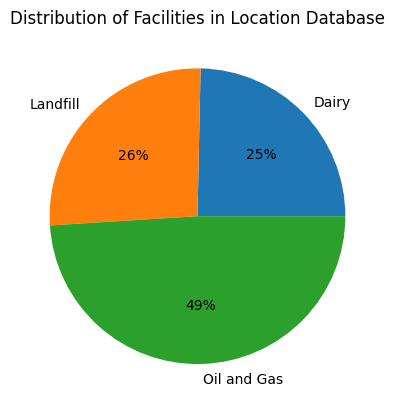

In [ ]:
axis = locations_pivot.plot(kind='pie',
                            autopct='%1.0f%%',
                            ylabel="",
                            title="Distribution of Facilities in Location Database")

Text(0.5, 0, 'meters')

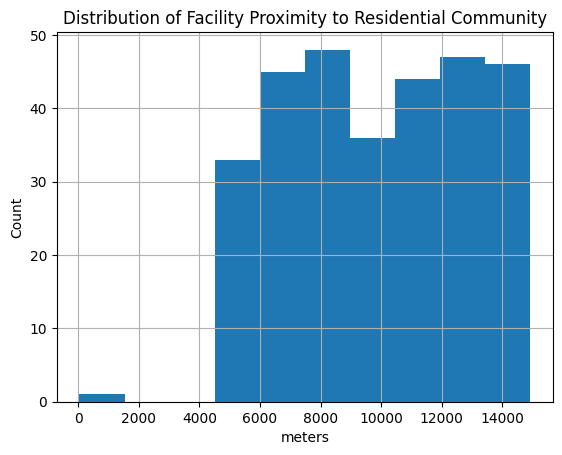

In [ ]:
axes = df_locations.hist(column='Rez_Prox_m')
axes[0][0].set_title(f"Distribution of Facility Proximity to Residential Community")
axes[0][0].set_ylabel(f"Count")
axes[0][0].set_xlabel(f"meters")

### Event Records
Notes:
1) Columns renamed to be consistent with other data tables

In [ ]:
df_records = pd.read_csv(local_data_directory + 'event_records.dat',
                         parse_dates=['timestamp'])
column_new_names = {'timestamp': 'Timestamp',
                    'location_id': 'Location_ID',
                    'record_type': 'Record_Type',
                    'event_status': 'Event_Status',
                    }
df_records.rename(columns=column_new_names, inplace=True)

df_records.info()
display(df_records)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73616 entries, 0 to 73615
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Timestamp     73616 non-null  datetime64[ns]
 1   Location_ID   73616 non-null  int64         
 2   Record_Type   73616 non-null  int64         
 3   Event_Status  73616 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.2 MB


,Timestamp,Location_ID,Record_Type,Event_Status
0,2024-01-02 00:06:00,31,1,0
1,2024-01-02 00:16:00,256,1,0
2,2024-01-02 00:20:00,286,1,0
3,2024-01-02 00:26:00,263,1,0
4,2024-01-02 00:27:00,25,1,0
...,...,...,...,...
73611,2025-01-02 21:42:00,60,1,0
73612,2025-01-03 04:59:00,161,1,1
73613,2025-01-03 07:23:00,122,1,2
73614,2025-01-03 09:54:00,122,2,2


### Event Types Grouped by Record_Type and Event_Status

In [ ]:
satellite_pivot = pd.pivot_table(df_records,
                                 index=['Record_Type', 'Event_Status'],
                                 aggfunc='size',
                                 )
satellite_pivot.rename('Count', inplace=True)
df_satellite_pivot = pd.DataFrame(satellite_pivot)
display(df_satellite_pivot)
# Note dataframe is indexed [Record_type, Event_Status]
# To get Record_type 2, Event_Status 1 Counts used df_satellite_pivot.loc[2, 1]

Count
Record_Type Event_Status       
1           0             70519
            1               306
            2               383
            3                 1
            4              2245
2           0                36
            1                68
            2                58

### Join/Merge records and their associated locations

In [ ]:
df_merged = pd.merge(left=df_records, right=df_locations, left_on=["Location_ID"],
                     right_on=["Location_ID"]).sort_values('Timestamp').reset_index(drop=True)

In [ ]:
df_merged.describe()

,Location_ID,Record_Type,Event_Status,Rez_Prox_m
count,73616.000000,73616.000000,73616.000000,73616.000000
mean,150.324889,1.002201,0.139087,9905.210253
std,86.547133,0.046859,0.705524,2981.093245
min,1.000000,1.000000,0.000000,45.000000
25%,75.000000,1.000000,0.000000,7353.000000
50%,150.000000,1.000000,0.000000,10122.000000
75%,225.000000,1.000000,0.000000,12666.000000
max,300.000000,2.000000,4.000000,14919.000000


# Create Methane Plume Ticketing System

## Create TicketManager to Manage Plume Ticketing

In [ ]:
ticket_manager = TicketManager()

## Add Satellite and Operator Data to TicketManager

In [ ]:
for index, row in df_merged.iterrows():
  ticket_manager.add_row(index, row)

## Ticket System Visualization
An initial visualization of the data and key metrics was performed to get a sense of the dataset and to help ground truth the Question and Answer section below.

### Ticket System Key Statistics

In [ ]:
# Show ticket manager diagnostics
print(ticket_manager)

Ticket Manager Data Summary

Number of data rows processed: 73616
Number of unique location IDs: 300
Total plumes detected: 690
Number of plume confirmations: 68
Number of plume fixed: 58
Number of total tickets: 108
Number of open tickets: 50
Number of closed tickets: 58
Number of orphaned facility responses: 0
Number of orphaned cloudy events: 2028
Number of orphaned no plume events: 64170


### Distribution of plumes by facility

In [ ]:
# Convert Plume Database into DataFrame for plotting/inspection
# Note, this codeblock is undocumented, but here for completeness
# You can skip this codeblock and look at results in the next cells

row_filter_a = (df_merged['Record_Type'] == 1) & (df_merged['Event_Status'].between(1, 3, inclusive='both'))
df = df_merged[row_filter_a].groupby(['Industrial_Sector', 'Location_ID']).count()
df.rename(columns={'Timestamp': 'Count'}, inplace=True)
df = df.reset_index()
df = df[df['Count'] > 0]
df = df.reset_index()
df.drop(columns=['index', 'Record_Type', 'Event_Status', 'Rez_Prox_m'], inplace=True)

dairy = df[df['Industrial_Sector'] == 'Dairy']['Count'].to_numpy()
oil_and_gas = df[df['Industrial_Sector'] == 'Oil and Gas']['Count'].to_numpy()
landfill = df[df['Industrial_Sector'] == 'Landfill']['Count'].to_numpy()
all_sectors = np.concatenate((dairy, oil_and_gas, landfill))

df_num_plumes = {'Dairy': dairy, 'Oil and Gas': oil_and_gas, 'Landfill': landfill, 'All Sectors': all_sectors}
df_num_plumes = dict_to_data_frame(df_num_plumes)

In [ ]:
df_num_plumes.describe()

,Dairy,Oil and Gas,Landfill,All Sectors
count,17.000000,62.000000,25.000000,104.000000
mean,7.647059,6.500000,6.280000,6.634615
std,4.581773,3.805733,3.713938,3.906822
min,2.000000,2.000000,1.000000,1.000000
25%,4.000000,4.000000,3.000000,4.000000
50%,7.000000,6.000000,5.000000,6.000000
75%,10.000000,8.000000,8.000000,8.000000
max,20.000000,25.000000,16.000000,25.000000


In [ ]:
# histogram bin ranges
bins = list(range(0, 30, 3))

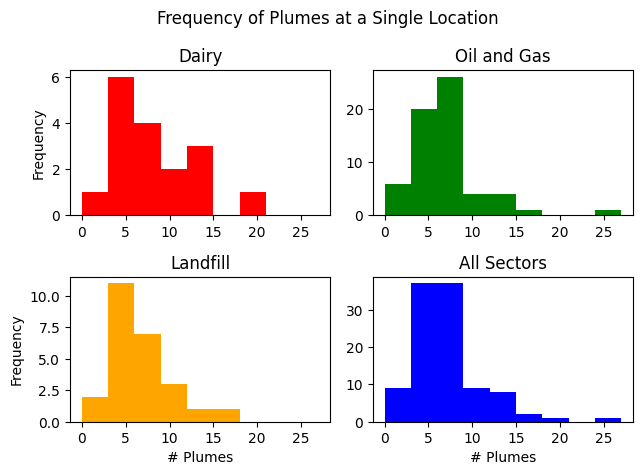

In [ ]:
plot_histogram(df_num_plumes,
               bins,
               same_y_limits=False,
               figure_title='Frequency of Plumes at a Single Location',
               y_label='Frequency',
               x_label='# Plumes',
               );

# Question 1
What are the total number of methane plumes observed by satellite broken out by industrial sector?  Overall, what is the percentage of the time a satellite observes a plume for each sector?

## Part A
1.	What are the total number of methane plumes observed by satellite broken out by industrial sector?

### Answer Methodology
1. Create a filter to extract only the event rows with plume measurements
2. Create a new dataframe that is a pivot plume measures by Industrial_Sector and Event_Status
3. Add summary columns to pivot
4. Display pivot dataframe

In [ ]:
# Filter results of the merged dataframe for plume detections
row_filter_a = (df_merged['Record_Type'] == 1) & (df_merged['Event_Status'].between(1, 3, inclusive='both'))

df_1a = pd.pivot_table(df_merged[row_filter_a],
                       index=['Industrial_Sector'],
                       columns=['Event_Status'],
                       aggfunc='size',
                       )
# Add summary columns
df_1a.loc['All Sectors'] = df_1a.sum(axis=0)
df_1a.loc[:, 'All Plumes'] = df_1a.sum(axis=1)

### Answer

In [ ]:
display(df_1a)

Event_Status,1,2,3,All Plumes
Industrial_Sector,,,,
Dairy,65,65,0,130
Landfill,64,93,0,157
Oil and Gas,177,225,1,403
All Sectors,306,383,1,690


## Part B
Overall, what is the percentage of the time a satellite observes a plume for each sector?

Notes:
1)

### Answer Methodology
1. This question is interpreted as what are percentage of satellite observations that are a plume (Event Status 1, 2, or 3) grouped by sector
2. Filter the event rows to extract satellite readings
3. Create a new dataframe that is a pivot plume measures by Industrial_Sector and Event_Status
4. Add summary columns to pivot
5. Display pivot dataframe

In [ ]:
# Filter results of the merged dataframe for all satellite measurements
row_filter_b = df_merged['Record_Type'] == 1
df_1b = pd.pivot_table(df_merged[row_filter_b],
                       index=['Industrial_Sector'],
                       columns=['Event_Status'],
                       aggfunc='size',
                       )
# Add summary columns
df_1b.loc['All Sectors'] = df_1b.sum(axis=0)
df_1b.loc[:, 'Num Events'] = df_1b.sum(axis=1)
df_1b['Num Plumes'] = df_1b[1] + df_1b[2] + df_1b[3]
df_1b['% Obs'] = df_1b['Num Plumes'] / df_1b['Num Events'] * 100
df_1b = df_1b.round({'% Obs': 3})

### Answer

In [ ]:
display(df_1b)

Event_Status,0,1,2,3,4,Num Events,Num Plumes,% Obs
Industrial_Sector,,,,,,,,
Dairy,17399,65,65,0,574,18103,130,0.718
Landfill,18599,64,93,0,583,19339,157,0.812
Oil and Gas,34521,177,225,1,1088,36012,403,1.119
All Sectors,70519,306,383,1,2245,73454,690,0.939


# Question 2
What percentage of satellite plume observations at a given location were confirmed by the facility operators as a leak?  (i.e. satellites observed one or more methane plumes at a location and the operator subsequently reported the discovery of a methane leak at that location) Do these confirmation rates vary by industrial sector?

### Answer Methodology
1. Create a dataframe with the plume counts by sector from Question 1
2. Use the ticket_manager to determine the number of confirmation events and the number of associated plumes that are confirmed (by sector)
3. Perform aggregate statistics and present as a dataframe

In [ ]:
# Use ticket manager to count confirm events and related plumes
confirm_counts, plume_counts = ticket_manager.count_confirmed_plumes()

In [ ]:
df_2a = df_1b.copy()[['Num Plumes']]
confirm_counts_series = pd.Series(confirm_counts, name='Confirm Events')
plume_counts_series = pd.Series(plume_counts, name='Confirmed Plumes')

df_2a['Confirm Events'] = confirm_counts_series
df_2a['Confirmed Plumes'] = plume_counts_series
df_2a['% Plumes Confirmed'] = df_2a['Confirmed Plumes'] / df_2a['Num Plumes'] * 100
df_2a = df_2a.round({'% Plumes Confirmed': 1})

### Answer

In [ ]:
display(df_2a)

Event_Status,Num Plumes,Confirm Events,Confirmed Plumes,% Plumes Confirmed
Industrial_Sector,,,,
Dairy,130,13,83,63.8
Landfill,157,19,109,69.4
Oil and Gas,403,36,194,48.1
All Sectors,690,68,386,55.9


# Question 3
What was the average amount of time it took for an operator to confirm the detection of a leak from when a plume was first observed by the satellite for the given location?  How long on average did it take facility operators to fix a leak once they were able to confirm its presence?

## Part A
What was the average amount of time it took for an operator to confirm the detection of a leak from when a plume was first observed by the satellite for the given location?


### Answer Methodology
1. Use the ticket_manager to determine the duration time for leak confirmation by sector.
2. See documentation of the TicketManager.confirm_durations method for details.

In [ ]:
# Ticket manager will create a list of confirm durations by sector
confirm_durations = ticket_manager.confirm_durations()
# Convert the list of confirm durations to a dataframe
df_confirm = dict_to_data_frame(confirm_durations)

### Answer

The mean leak confirmation time (and other statistics) are show below.
The mean leak confirmation time varied by sector, but was approximately 3.6 days on average.

In [ ]:
df_confirm.describe()

,Dairy,Landfill,Oil and Gas,All Sectors
count,13.000000,19.000000,36.000000,68.000000
mean,3.754006,3.989583,3.362307,3.612459
std,2.365978,2.092168,2.338385,2.261159
min,0.567361,0.124306,0.068056,0.068056
25%,1.886111,2.688889,1.602951,1.885069
50%,3.777778,3.843750,3.161111,3.712847
75%,6.154861,5.977778,5.015451,5.490278
max,7.222222,7.483333,7.626389,7.626389


In [ ]:
# Find Suitable Histogram Bins
confirm_bins = find_hist_bins(confirm_durations['All Sectors'])

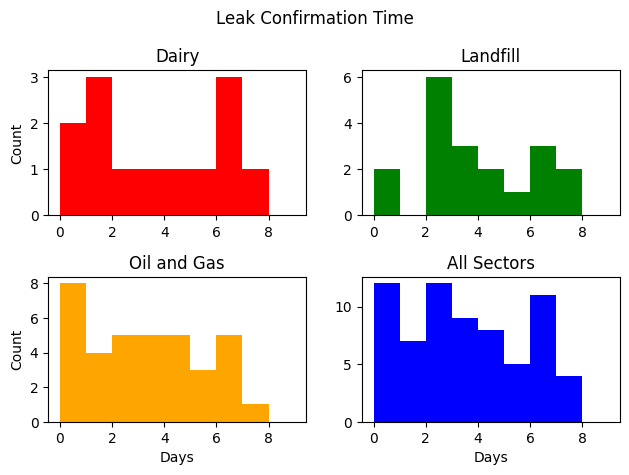

In [ ]:
figure, axes = plot_histogram(df_confirm,
                              confirm_bins,
                              figure_title="Leak Confirmation Time"
                              )

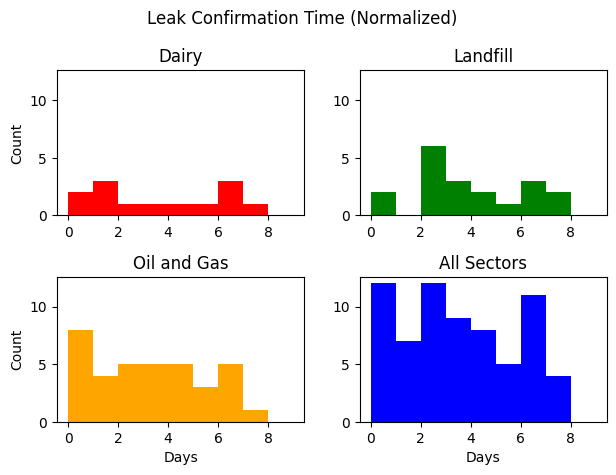

In [ ]:
figure, axes = plot_histogram(df_confirm,
                              confirm_bins,
                              same_y_limits=True,
                              figure_title="Leak Confirmation Time (Normalized)"
                              )

## Part B
How long on average did it take facility operators to fix a leak once they were able to confirm its presence?

### Answer Methodology
1. Use the ticket_manager to determine the fix time for each facility by sector.
2. See documentation of the TicketManager.fix_durations method for details.

In [ ]:
# Ticket manager will create a list of fix durations by sector
fix_durations = ticket_manager.fix_durations()
# Convert the list of fix durations to a dataframe
df_fix = dict_to_data_frame(fix_durations)

### Answer

The mean leak fix time (and other statistics) are show below.
The mean fix confirmation time varied by sector:
Dairy (2.0 days), Landfill (1.3 days), Oil and Gas (2.1 days), All Sectors (1.9 days).

In [ ]:
df_fix.describe()

,Dairy,Landfill,Oil and Gas,All Sectors
count,10.000000,16.000000,32.000000,58.000000
mean,2.013681,1.317665,2.083268,1.860069
std,1.213614,0.921305,0.925661,1.018146
min,0.299306,0.313889,0.197222,0.197222
25%,0.936458,0.670312,1.566840,0.946354
50%,2.495486,0.953125,2.145833,1.873958
75%,2.695312,1.818576,2.801563,2.724479
max,3.726389,3.127778,3.899306,3.899306


In [ ]:
# Find Suitable Histogram Bins
fix_bins = find_hist_bins(fix_durations['All Sectors'])

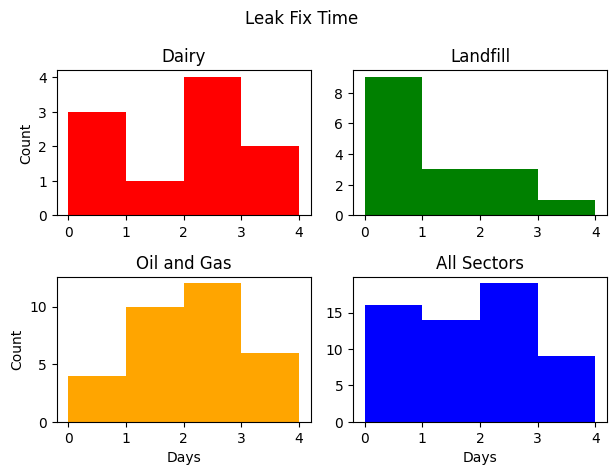

In [ ]:
figure, axes = plot_histogram(df_fix,
                              fix_bins,
                              figure_title="Leak Fix Time"
                              )

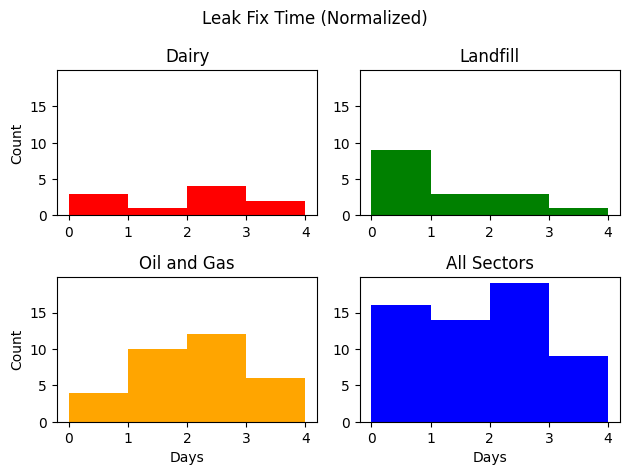

In [ ]:
figure, axes = plot_histogram(df_fix,
                              fix_bins,
                              same_y_limits=True,
                              figure_title="Leak Fix Time (Normalized)"
                              )

# Question 4
What percentage of observed methane leaks were reported fixed by an operator but still had methane plumes observed by the satellite at the location afterwards?

### Answer Methodology
1. This question is interpreted as, "Of all the facilities that reported methane leaks were fixed, what fraction of these facilities had a subsequent satellite plume detected"
2. The ticket_manager method plume_after_fix() was used to determine which facilities had closed a ticket with a leak fixed response and then subsequently a new ticket was created at that facility.


## Analysis

In [ ]:
plume_by_sector_counts, plume_by_facility_counts = ticket_manager.plume_after_fix()
suspect_facilities_counts = plume_by_facility_counts

In [ ]:
# Find the number of plumes by sector detected at a facility after it indicated
# the leak was fixed
plume_by_sector_counts

{'Dairy': 0, 'Landfill': 0, 'Oil and Gas': 7, 'All Sectors': 7}

In [ ]:
# Find the facilities associated with plumes after fix
plume_by_facility_counts

{243: 2, 292: 2, 177: 2, 122: 1}

In [ ]:
# Find the percentage of times a facility reported a leak as fixed
# that subsequently was found to be still leaking

In [ ]:
count_operator_leak_after_fix = len(plume_by_facility_counts)
total_count_operator_reports_fixed = df_satellite_pivot.loc[2, 2][0]
fraction_leak_after_fix = count_operator_leak_after_fix / total_count_operator_reports_fixed
count_operator_leak_after_fix, total_count_operator_reports_fixed, fraction_leak_after_fix

(4, 58, 0.06896551724137931)

In [ ]:
# Summary ticketing information about plume after fix facilities
for location_id in plume_by_facility_counts:
  for ticket in ticket_manager.tickets[location_id]:
    print(ticket)

{   'id': 58,
    'location id': 243,
    'is_open': False,
    'sector': 'Oil and Gas',
    'creation_time': Timestamp('2024-07-15 05:46:00'),
    'confirm_time': Timestamp('2024-07-20 03:12:00'),
    'fixed_time': Timestamp('2024-07-22 05:56:00'),
    'satellite plume count': 6,
    'self.satellite_non_plume_count': 0,
    'satellite measurement count': 6,
    'self.plume_count_after_no_leak_detected': 0}
{   'id': 63,
    'location id': 243,
    'is_open': True,
    'sector': 'Oil and Gas',
    'creation_time': Timestamp('2024-07-22 06:27:00'),
    'confirm_time': None,
    'fixed_time': None,
    'satellite plume count': 2,
    'self.satellite_non_plume_count': 106,
    'satellite measurement count': 108,
    'self.plume_count_after_no_leak_detected': 0}
{   'id': 82,
    'location id': 292,
    'is_open': False,
    'sector': 'Oil and Gas',
    'creation_time': Timestamp('2024-09-23 18:13:00'),
    'confirm_time': Timestamp('2024-09-26 01:46:00'),
    'fixed_time': Timestamp('2024

In [ ]:
# Detailed ticketing information about plume after fix facilities
for location_id in plume_by_facility_counts:
  for ticket in ticket_manager.tickets[location_id]:
    print(repr(ticket))

{   'id': 58,
    'location id': 243,
    'is_open': False,
    'sector': 'Oil and Gas',
    'creation_time': Timestamp('2024-07-15 05:46:00'),
    'confirm_time': Timestamp('2024-07-20 03:12:00'),
    'fixed_time': Timestamp('2024-07-22 05:56:00'),
    'satellite plume count': 6,
    'self.satellite_non_plume_count': 0,
    'satellite measurement count': 6,
    'self.plume_count_after_no_leak_detected': 0,
    'satellite_data': {   <SatelliteEvent.no_methane_plume: 0>: [],
                          <SatelliteEvent.small_methane_plume: 1>: [],
                          <SatelliteEvent.medium_methane_plume: 2>: [   39258,
                                                                        39574,
                                                                        39614,
                                                                        39842,
                                                                        40136,
                                                       

## Answer

Four locations had a total of 7 leaks detected by satellite after they previously indicated that a leak was fixed.  All four of these facilities are in the Oil and Gas Sector.  Of the 58 instances that facilities indicated they fixed a leak only 4 had subsequent leaks indicating that approximately 6.9% (4/58) facilities had measurements after leaks.

Table 1.
Facility ID, Number of Satellite Plumes Detected subsequently
 122, 1
 177, 2
 243, 2
 292, 2


# Question 5
How many observed methane leaks remain unresolved? (i.e. a plume is still being observed, or the absence of a plume has not yet been confirmed by satellite

### Answer Methodology
There are a variety of reasonable ways to address this question.  One way to consider a leak resolved is if an operator confirms and fixes a leak, and then CARB has multiple satellite non-detects above the facility to confirm there is no longer a leak.  Perhaps a similar, but more extensive verification process is required if a facility issues a no-leak-detected event rather than a fixed event.  One could envision the usefulness of CARB administrative event protocols/codes to close open plume tickets.

For this analysis, a leak is considered unresolved if its associated ticket has not been closed with a leak-fixed event.  In addition, all of the plumes (both before and after a fixed event) associated with the facilities that had plumes detected after they fixed them are considered unresolved for this analysis.

This question will be answered in the following steps.
1. Use the Ticket Manager to determine how many plumes were detected after an operator indicated that they could find a leak.
2. Use the Ticket Manager to determine plumes associated with tickets that are not closed.
3. Find all plumes associated with the Facilities that indicated they fixed a leak, but then plumes were subsequently detected.


Find plume counts detected at facilities after an operator indicated that no leak was detected.

In [ ]:
no_leak_found_by_sector, no_leak_found_by_facility = ticket_manager.plume_after_no_leak_found()
no_leak_found_by_sector

{'Dairy': 31, 'Landfill': 22, 'Oil and Gas': 111, 'All Sectors': 164}

Find fixed plumes

In [ ]:
fixed_by_sector = ticket_manager.fixed_plumes()

In [ ]:
fixed_by_sector

{'Dairy': 49, 'Landfill': 77, 'Oil and Gas': 162, 'All Sectors': 288}

Find plumes that are unresolved because they are on open tickets

In [ ]:
# Ticket manager will create a list of keyed by sector and individual facilities
open_ticket_by_sector, open_ticket_by_facility = ticket_manager.unresolved_plumes()

In [ ]:
open_ticket_by_sector

{'Dairy': 81, 'Landfill': 80, 'Oil and Gas': 241, 'All Sectors': 402}

Sum fixed and unresolved as a double check
Note that these calculations agree with Question 1 results

In [ ]:
total_plumes = {}
for key in fixed_by_sector:
  total_plumes[key] = fixed_by_sector[key] + open_ticket_by_sector[key]
total_plumes

{'Dairy': 130, 'Landfill': 157, 'Oil and Gas': 403, 'All Sectors': 690}

Find the plumes associated with the fixed but later detected associated with Question 4

In [ ]:
# Plume counts after a leak fixed event at suspect facilities
suspect_facilities_counts

{243: 2, 292: 2, 177: 2, 122: 1}

In [ ]:
suspect_plume_counts = {}
for location_id in suspect_facilities_counts:
  plume_count = ticket_manager.plumes_by_location_id(location_id)
  suspect_plume_counts[location_id] = plume_count

In [ ]:
# Plume counts before and after a leak fixed event at suspect facilities
suspect_plume_counts

{243: 8, 292: 6, 177: 7, 122: 6}

In [ ]:
total_suspect_plumes = sum(suspect_plume_counts.values())
total_suspect_plumes

27

In [ ]:
# Update total plumes to include fixed + suspect plumes
open_ticket_by_sector['Oil and Gas'] += total_suspect_plumes
open_ticket_by_sector['All Sectors'] += total_suspect_plumes
open_ticket_by_sector

{'Dairy': 81, 'Landfill': 80, 'Oil and Gas': 268, 'All Sectors': 429}

## Answer
It was found that 164 plumes were detected at facilities after they indicated that no leak was detected.  As such, using a facility response of no leak detected would not be a good method to consider a plume resolved on its own.

For this analysis, it was determined that the following plumes should be considered unresolved because they were on open tickets:

{'Dairy': 81, 'Landfill': 80, 'Oil and Gas': 241, 'All Sectors': 402}

In addition, the 27 plumes that are associated with the 4 facilities that had plume detections after they reported a leak fixed (7 of which occurred after the leak fixed event and 20 before) should also be considered unresolved.

As such, the total plumes to be considered unresolved should be:
{'Dairy': 81, 'Landfill': 80, 'Oil and Gas': 268, 'All Sectors': 429}


# Question 6
Are there any methane plume observations found in the dataset that you feel CARB should treat as a high priority to investigate further?


## Answer
There is only one large plume event in the sample dataset that occurred at facility 122 at timestamp 2025-01-04 12:01.  This single large plume occurred at one of the four facilities that had satellite plume detection after the operator indicated a leak was fixed.  Given the large size of the plume, the fact that the facility has had 6 satellite total plume detections over the sampling period, and is at a site where plumes have been detected after fixing make it the highest priority for CARB to investigate further.



# Question 7
Briefly describe your approach to answering these questions.  What tools and techniques did you use?


### Answer
This notebook documents all tools and techniques used to answer Questions 1-6